# 📑 &nbsp; Deep Learning. Cultivar Recognition

In this project, we'll classify images from the dataset
<a href='https://www.kaggle.com/olgabelitskaya/tomato-cultivars'>Tomato Cultivars</a>.<br/>
The content is about 700-800 images (160x160x3) with 15 tomato cultivars<br/>
stored in the file of <i>Hierarchical Data Format (HDF5)</i>and it's in the building process.<br/>
In the original dataset, photo files have the extension PNG and they are labeled by file prefixes.<br/>
We'll preprocess the images, represent their examples, then train neural networks and other algorithms.<br/> 
We are going to apply:<br/>
1) <a href='https://scikit-learn.org/stable/'>scikit-learn: Machine Learning in Python</a><br/>
2) <a href='https://keras.io/'>Keras: a Python Deep Learning Library</a><br/>
3) <a href='https://pytorch.org/'>PyTorch: an Open Source Machine Learning Framework</a>.<br/>
## ✒️ &nbsp; Importing Libraries and Defining Helpful Functions

In [1]:
!python3 -m pip install --upgrade pip \
--user --quiet --no-warn-script-location
!python3 -m pip install neural_structured_learning \
--user --quiet --no-warn-script-location
!python3 -m pip install tensorflow_hub \
--user --quiet --no-warn-script-location

In [2]:
spath='/root/.local/lib/python3.6/'
import sys; sys.path.append(spath)
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display,HTML
import h5py,urllib,torch,tensorflow as tf
import pandas as pd,numpy as np,pylab as pl
from sklearn.ensemble import RandomForestClassifier as sRFC
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.metrics import classification_report
import tensorflow_hub as th,neural_structured_learning as nsl
import tensorflow.keras.callbacks as tkc,\
tensorflow.keras.utils as tku,tensorflow.keras.layers as tkl
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf,torch.nn as tnn
dev=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tmodel=models.vgg16(pretrained=True,progress=False)
from IPython.core.magic import register_line_magic
#@tf.autograph.experimental.do_not_convert

 ## ✒️ &nbsp; Data Loading and Preprocessing

In [3]:
file_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
file_name='TomatoCultivars160.h5'; img_size=160
def get_file(file_path,file_name):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
get_file(file_path,file_name)
with h5py.File(file_name,'r') as f:
    keys=list(f.keys())
    display(HTML('<p>file keys: '+', '.join(keys)+'</p>'))
    images=np.array(f[keys[0]])
    images=tf.image.resize(images,[img_size,img_size]).numpy()
    labels=np.array(f[keys[1]])
    names=[el.decode('utf-8')for el in f[keys[2]]]
    f.close()

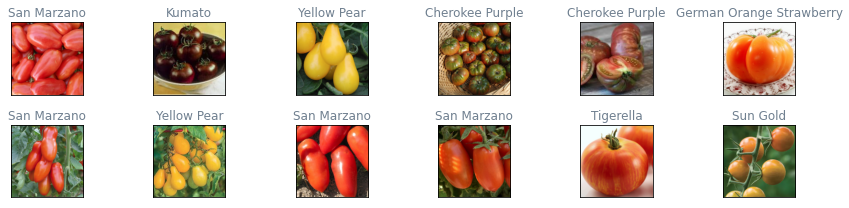

,train,valid,test
image shape,"(622, 160, 160, 3)","(77, 160, 160, 3)","(77, 160, 160, 3)"
image type,float32,float32,float32
label shape,"(622,)","(77,)","(77,)"
label type,int32,int32,int32


In [4]:
N=labels.shape[0]; n=int(.1*N)
num_classes=len(names)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
def display_imgs(images,labels,names,n=12):
    fig=pl.figure(figsize=(12,3))
    for i in range(0,n):
        ax=fig.add_subplot(2,n//2,i+1,xticks=[],yticks=[])
        ax.set_title(
            names[labels[i]],color='slategray',
            fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names); display(df)

In [5]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
batch_size2=8
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=np.transpose(x_train,(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=np.transpose(x_valid,(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=np.transpose(x_test,(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,batch_size=batch_size2)}

0.43815878 0.2930987


image dimensions: torch.Size([8, 3, 160, 160])
label dimensions: torch.Size([8])


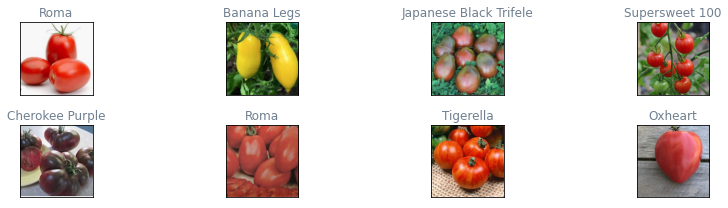

In [6]:
@register_line_magic
def display_data_imgs(data):
    global names
    for images,labels in dataloaders[data]:  
        print('image dimensions: %s'%str(images.shape))
        print('label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,names,8)
        break
%display_data_imgs valid

## ✒️ &nbsp; Classifiers
### Sklearn Algorithms

In [7]:
def classifier_fit_score(classifier,x_train,x_test,y_train,y_test):
    classifier.fit(x_train,y_train)     
    y_clf_train=classifier.predict(x_train)
    y_clf_test=classifier.predict(x_test)        
    acc_clf_train=round(accuracy_score(y_train,y_clf_train),4)
    acc_clf_test=round(accuracy_score(y_test,y_clf_test),4)
    loss_clf_train=round(hamming_loss(y_train,y_clf_train),4)
    loss_clf_test=round(hamming_loss(y_test,y_clf_test),4)  
    return [y_clf_train,y_clf_test,acc_clf_train,acc_clf_test,
            loss_clf_train,loss_clf_test]
[y_srfc_train,y_srfc_test,acc_srfc_train,
 acc_srfc_test,loss_srfc_train,loss_srfc_test]=\
classifier_fit_score(
    sRFC(),x_train.reshape(-1,3*img_size**2),
    x_test.reshape(-1,3*img_size**2),y_train,y_test)
print(classification_report(y_test,y_srfc_test))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.38      0.38      0.38         8
           2       0.14      0.67      0.24         3
           3       0.25      0.40      0.31         5
           4       0.50      0.50      0.50         2
           5       0.50      0.56      0.53         9
           6       0.00      0.00      0.00         6
           7       0.43      0.50      0.46         6
           8       0.00      0.00      0.00         6
           9       0.50      0.25      0.33         4
          10       0.25      1.00      0.40         2
          11       0.33      0.14      0.20         7
          12       0.00      0.00      0.00         3
          13       0.33      0.20      0.25         5
          14       0.00      0.00      0.00         6

    accuracy                           0.31        77
   macro avg       0.28      0.35      0.28        77
weighted avg       0.29   

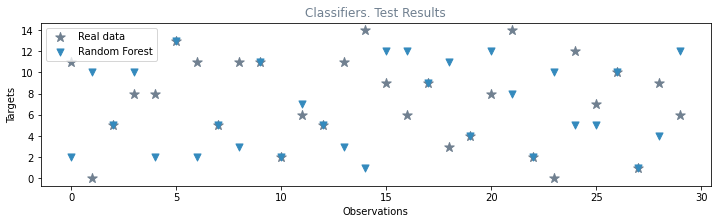

In [8]:
def plot_predict(y_predict,label_predict,t=30,fig_size=12):
    pl.figure(figsize=(fig_size,fig_size//4)); x=range(t)
    pl.scatter(x,y_test[:t],marker='*',s=100,
               color='slategray',label='Real data')
    pl.scatter(x,y_predict[:t],marker='v',s=50,
               color='#348ABD',label=label_predict)
    pl.xlabel('Observations'); pl.ylabel('Targets') 
    pl.title('Classifiers. Test Results',color='slategray',
             fontdict={'fontsize':'large'})
    pl.legend(loc=2,fontsize=10)
    pl.tight_layout; pl.show()
plot_predict(y_srfc_test,'Random Forest')

CNN Based Models with Adversarial Regularization



In [9]:
batch_size=64; epochs=30
base_model=tf.keras.Sequential([
    tkl.Input((img_size,img_size,3),name='input'),
    tkl.Conv2D(32,(5,5),padding='same'),
    tkl.Activation('relu'),
    tkl.MaxPooling2D(pool_size=(2,2)),
    tkl.Dropout(.25),
    tkl.Conv2D(196,(5,5)),
    tkl.Activation('relu'),    
    tkl.MaxPooling2D(pool_size=(2,2)),
    tkl.Dropout(.25),
    tkl.GlobalMaxPooling2D(),    
    tkl.Dense(512),
    tkl.Activation('relu'),
    tkl.Dropout(.25),
    tkl.Dense(128),
    tkl.Activation('relu'),
    tkl.Dropout(.25),
    tkl.Dense(num_classes,activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
model_weights='/tmp/checkpoint'
checkpointer=tkc.ModelCheckpoint(
    filepath=model_weights,verbose=2,save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',save_best_only=True)
adv_model.compile(optimizer='nadam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [10]:
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':y_train})\
     .batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':y_valid})\
     .batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,validation_data=valid,
              verbose=2,callbacks=[checkpointer],
              validation_steps=valid_steps,epochs=epochs);

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


10/10 - 48s - loss: 3.2581 - sparse_categorical_crossentropy: 2.7149 - sparse_categorical_accuracy: 0.0884 - scaled_adversarial_loss: 0.5433 - val_loss: 3.2171 - val_sparse_categorical_crossentropy: 2.6804 - val_sparse_categorical_accuracy: 0.0469 - val_scaled_adversarial_loss: 0.5367

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.04688, saving model to /tmp/checkpoint
Epoch 2/30
10/10 - 3s - loss: 3.1005 - sparse_categorical_crossentropy: 2.5859 - sparse_categorical_accuracy: 0.1431 - scaled_adversarial_loss: 0.5146 - val_loss: 3.0655 - val_sparse_categorical_crossentropy: 2.5539 - val_sparse_categorical_accuracy: 0.1719 - val_scaled_adversarial_loss: 0.5116

Epoch 00002: val_sparse_categorical_accuracy improved from 0.04688 to 0.17188, saving model to /tmp/checkpoint
Epoch 3/30
10/10 - 3s - loss: 2.8263 - sparse_categorical_crossentropy: 2.3576 - sparse_categorical_accuracy: 0.1801 - scaled_adversarial_loss: 0.4687 - val_loss: 2.7323 - val_sparse_categorical_cr

In [11]:
adv_model.load_weights(model_weights)
adv_model.evaluate({'input':x_test,'label':y_test})

3/3 [==============================] - 2s 386ms/step - loss: 1.8040 - sparse_categorical_crossentropy: 1.4962 - sparse_categorical_accuracy: 0.4286 - scaled_adversarial_loss: 0.3078


[1.8039816617965698,
 1.4962106943130493,
 0.4285714328289032,
 0.30777087807655334]

### TFHub Models

In [12]:
def premodel(img_size,den,mh,num_classes):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((img_size,img_size,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(num_classes,activation='softmax')])
    model.compile(optimizer='nadam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    display(model.summary())
    return model
def cb(model_weights):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
    filepath=model_weights,verbose=2,save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [13]:
handle_base='mobilenet_v2_075_160'
mhandle='https://tfhub.dev/google/imagenet/{}/feature_vector/4'\
.format(handle_base)

In [14]:
model=premodel(img_size,1024,mhandle,num_classes)
history=model.fit(x=x_train,y=y_train,batch_size=32,
                  epochs=70,callbacks=cb(model_weights),
                  validation_data=(x_valid,y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              1382064   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                15375     
Total params: 2,709,183
Trainable params: 2,682,543
Non-trainable params: 26,640
_________________________________________________________________


None

Epoch 1/70
20/20 [==============================] - 22s 296ms/step - loss: 2.4057 - accuracy: 0.3083 - val_loss: 2.3102 - val_accuracy: 0.4286

Epoch 00001: val_accuracy improved from -inf to 0.42857, saving model to /tmp/checkpoint
Epoch 2/70
20/20 [==============================] - 4s 212ms/step - loss: 0.5491 - accuracy: 0.8294 - val_loss: 3.6731 - val_accuracy: 0.3766

Epoch 00002: val_accuracy did not improve from 0.42857
Epoch 3/70
20/20 [==============================] - 4s 211ms/step - loss: 0.6337 - accuracy: 0.8190 - val_loss: 3.1806 - val_accuracy: 0.5844

Epoch 00003: val_accuracy improved from 0.42857 to 0.58442, saving model to /tmp/checkpoint
Epoch 4/70
20/20 [==============================] - 4s 211ms/step - loss: 0.3277 - accuracy: 0.9178 - val_loss: 3.5312 - val_accuracy: 0.5195

Epoch 00004: val_accuracy did not improve from 0.58442
Epoch 5/70
20/20 [==============================] - 4s 211ms/step - loss: 0.4135 - accuracy: 0.8979 - val_loss: 5.1054 - val_accuracy: 0

In [17]:
model.load_weights(model_weights)
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 40ms/step - loss: 1.2464 - accuracy: 0.7532


[1.2463668584823608, 0.7532467246055603]

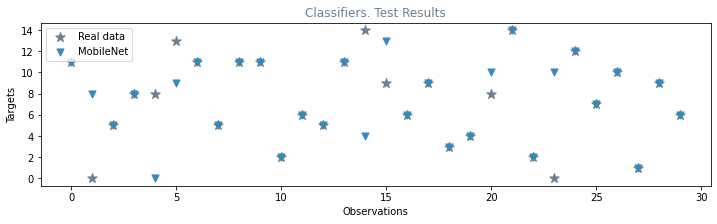

In [18]:
y_mob_test=np.argmax(model.predict(x_test),axis=-1)
plot_predict(y_mob_test,'MobileNet')

In [19]:
handle_base='inception_v3'
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)

In [20]:
model=premodel(img_size,1024,mhandle,num_classes)
history=model.fit(x=x_train,y=y_train,batch_size=32,
                  epochs=70,callbacks=cb(model_weights),
                  validation_data=(x_valid,y_valid))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1001)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1026048   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                15375     
Total params: 24,895,256
Trainable params: 24,860,824
Non-trainable params: 34,432
_________________________________________________________________


None

Epoch 1/70
20/20 [==============================] - 39s 666ms/step - loss: 3.3389 - accuracy: 0.1775 - val_loss: 12.4483 - val_accuracy: 0.2208

Epoch 00001: val_accuracy improved from -inf to 0.22078, saving model to /tmp/checkpoint
Epoch 2/70
20/20 [==============================] - 9s 438ms/step - loss: 1.8041 - accuracy: 0.5669 - val_loss: 2.6880 - val_accuracy: 0.3117

Epoch 00002: val_accuracy improved from 0.22078 to 0.31169, saving model to /tmp/checkpoint
Epoch 3/70
20/20 [==============================] - 9s 439ms/step - loss: 1.2627 - accuracy: 0.7538 - val_loss: 7.2820 - val_accuracy: 0.1688

Epoch 00003: val_accuracy did not improve from 0.31169
Epoch 4/70
20/20 [==============================] - 9s 437ms/step - loss: 1.5548 - accuracy: 0.6862 - val_loss: 131.7168 - val_accuracy: 0.0779

Epoch 00004: val_accuracy did not improve from 0.31169
Epoch 5/70
20/20 [==============================] - 9s 437ms/step - loss: 1.6258 - accuracy: 0.6968 - val_loss: 2784.0337 - val_accur

In [22]:
model.load_weights(model_weights)
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 103ms/step - loss: 1.7089 - accuracy: 0.6623


[1.7088767290115356, 0.6623376607894897]

### TorchVision Models

In [23]:
for param in tmodel.parameters(): param.requires_grad=False
tmodel.classifier[3].requires_grad=True
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [24]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    st1='epoch: %03d/%03d || batch: %03d/%03d || cost: %.4f'
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%20:
                print(st1%(epoch+1,epochs,batch_ids,
                      len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('epoch: %03d/%03d'%(epoch+1,epochs))
            print('valid acc/loss: %.2f%%/%.2f'%\
                  (model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,256),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(256,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())
%train_run 10

epoch: 001/010 || batch: 000/077 || cost: 2.6104
epoch: 001/010 || batch: 020/077 || cost: 2.3113
epoch: 001/010 || batch: 040/077 || cost: 1.2256
epoch: 001/010 || batch: 060/077 || cost: 1.9654
epoch: 001/010
valid acc/loss: 65.28%/1.20
epoch: 002/010 || batch: 000/077 || cost: 0.8721
epoch: 002/010 || batch: 020/077 || cost: 1.6732
epoch: 002/010 || batch: 040/077 || cost: 1.1148
epoch: 002/010 || batch: 060/077 || cost: 0.7166
epoch: 002/010
valid acc/loss: 70.83%/0.90
epoch: 003/010 || batch: 000/077 || cost: 0.6681
epoch: 003/010 || batch: 020/077 || cost: 1.0689
epoch: 003/010 || batch: 040/077 || cost: 0.8781
epoch: 003/010 || batch: 060/077 || cost: 0.8745
epoch: 003/010
valid acc/loss: 73.61%/0.81
epoch: 004/010 || batch: 000/077 || cost: 1.1385
epoch: 004/010 || batch: 020/077 || cost: 0.5715
epoch: 004/010 || batch: 040/077 || cost: 0.6876
epoch: 004/010 || batch: 060/077 || cost: 0.7723
epoch: 004/010
valid acc/loss: 68.06%/0.85
epoch: 005/010 || batch: 000/077 || cost: 0.

In [25]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('test acc: %.2f%%'%model_acc(tmodel,dataloaders['test']))

test acc: 75.00%
